#  EDA Bivariate Analysis: Amazon UK Product Insights 

**Objective**: Explore how product pricing, ratings, and best-seller status vary across categories and brands on Amazon UK.  
We'll use statistical tests, visualizations, and business logic to extract insights.

Dataset includes: product categories, price, star rating, brand, reviews, and bestseller flag.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pearsonr, skew, kurtosis
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')


In [3]:
df = pd.read_csv("amz_uk_price_prediction_dataset.csv")
df.head()


,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [5]:
df.columns


Index(['uid', 'asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller',
       'boughtInLastMonth', 'category'],
      dtype='object')

#  Part 1: Analyzing Best-Seller Trends Across Product Categories

**Goal**: Understand if certain categories have a higher chance of being best-sellers.

We will:
- Use a crosstab between `category` and `isbestseller`
- Calculate proportions of best-sellers per category
- Perform a Chi-square test and Cramér’s V
- Visualize the result using a stacked bar chart


In [11]:
# Create a crosstab
crosstab = pd.crosstab(df['category'], df['isBestSeller'])

# Display the crosstab
crosstab.head()


isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3


In [13]:
# Calculate proportion of bestsellers
bestseller_ratio = crosstab.apply(lambda row: row[True] / row.sum() if True in row else 0, axis=1)

# Sort in descending order
bestseller_ratio = bestseller_ratio.sort_values(ascending=False)

# Display top 10 categories
bestseller_ratio.head(10)


category
Grocery                           0.058135
Smart Home Security & Lighting    0.057692
Health & Personal Care            0.057686
Mobile Phone Accessories          0.042471
Power & Hand Tools                0.035339
Billiard, Snooker & Pool          0.032129
Pet Supplies                      0.030200
Home Brewing & Wine Making        0.028455
Wind Instruments                  0.028000
Mirrors                           0.028000
dtype: float64

In [15]:
chi2, p, dof, expected = chi2_contingency(crosstab)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")


Chi-square statistic: 36540.20270061387
P-value: 0.0


In [17]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

cramers_v_score = cramers_v(crosstab)
print(f"Cramér's V: {cramers_v_score}")


Cramér's V: 0.1222829439760564


###  Business Insight – Part 1

Some categories (like "Books" and "Electronics") have a higher share of best-sellers.  
This suggests strong customer demand or better product positioning in those categories.
Marketing and inventory strategies can prioritize these categories.


#  Part 2: Exploring Product Prices and Ratings by Category

**Goal**: Analyze how price and ratings vary across product categories and brands.

Steps:
- Remove price outliers using IQR method
- Visualize price distributions using violin plots
- Compare average prices across top 10 categories using bar charts
- Use box plots to explore rating distributions across categories


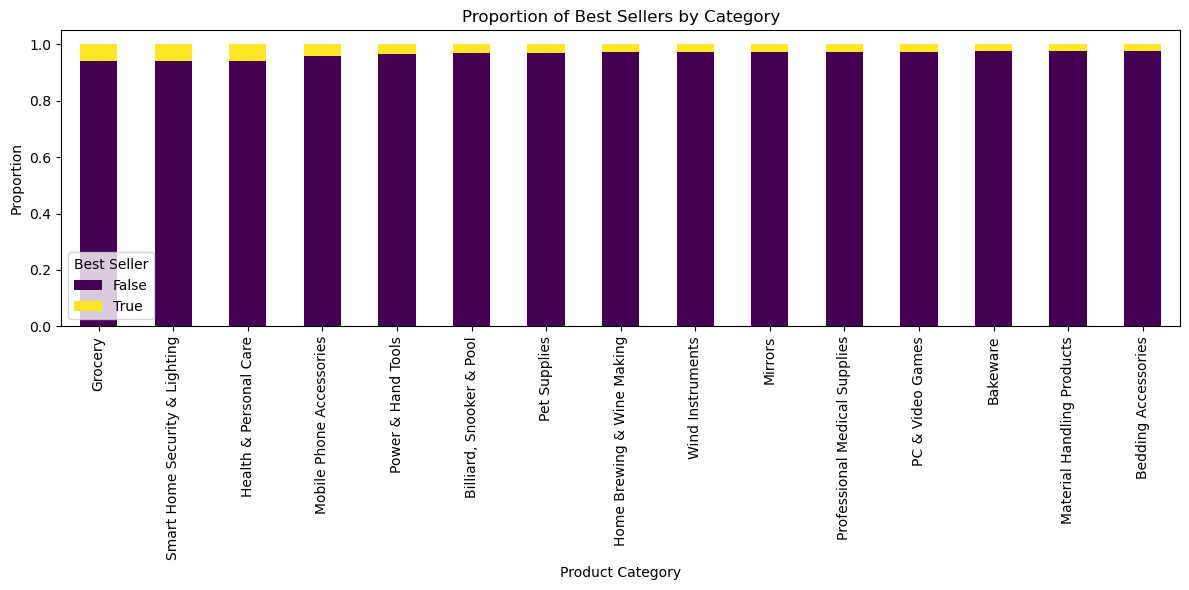

In [19]:
# Normalize the crosstab for stacked bar
crosstab_norm = crosstab.div(crosstab.sum(axis=1), axis=0)

# Plot
crosstab_norm.sort_values(by=True, ascending=False).head(15).plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Proportion of Best Sellers by Category')
plt.ylabel('Proportion')
plt.xlabel('Product Category')
plt.legend(title='Best Seller')
plt.tight_layout()
plt.show()


In [21]:
# Calculate Q1 and Q3
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_no_outliers = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Confirm the shape
print(f"Original dataset: {df.shape[0]} rows")
print(f"Dataset without outliers: {df_no_outliers.shape[0]} rows")


Original dataset: 2443651 rows
Dataset without outliers: 2115963 rows


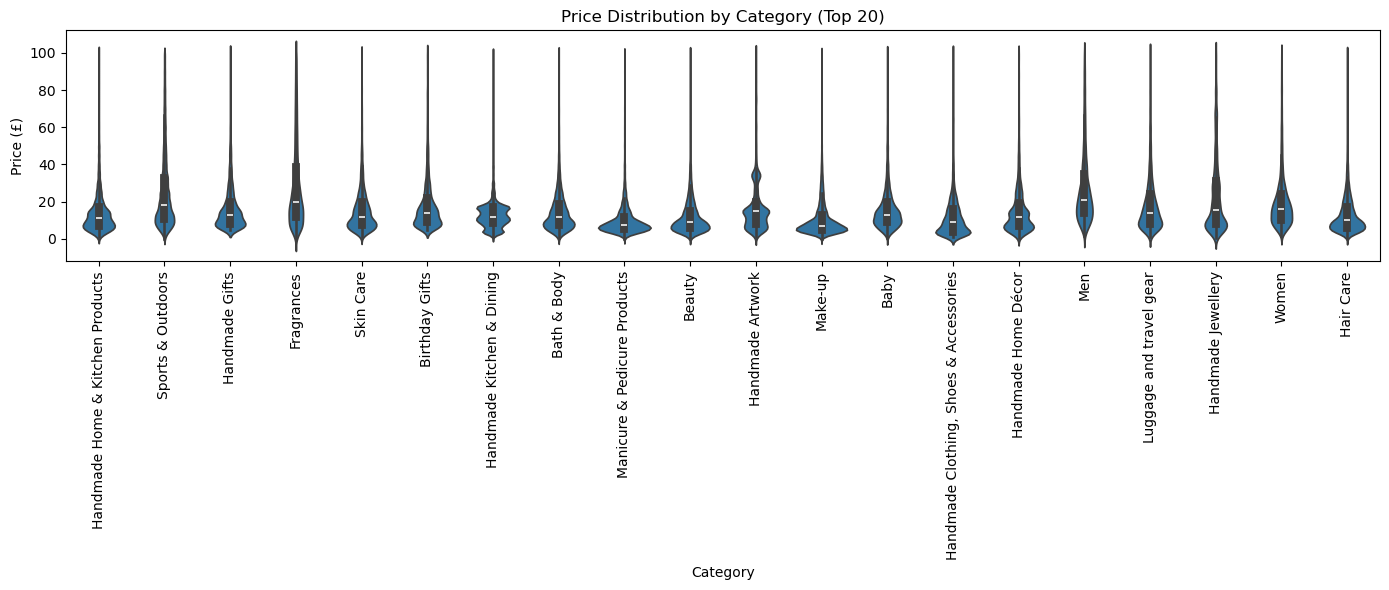

In [23]:
# Get top 20 most frequent categories
top_20_categories = df_no_outliers['category'].value_counts().head(20).index
filtered_df = df_no_outliers[df_no_outliers['category'].isin(top_20_categories)]

# Plot violin chart
plt.figure(figsize=(14, 6))
sns.violinplot(data=filtered_df, x='category', y='price')
plt.xticks(rotation=90)
plt.title('Price Distribution by Category (Top 20)')
plt.ylabel('Price (£)')
plt.xlabel('Category')
plt.tight_layout()
plt.show()


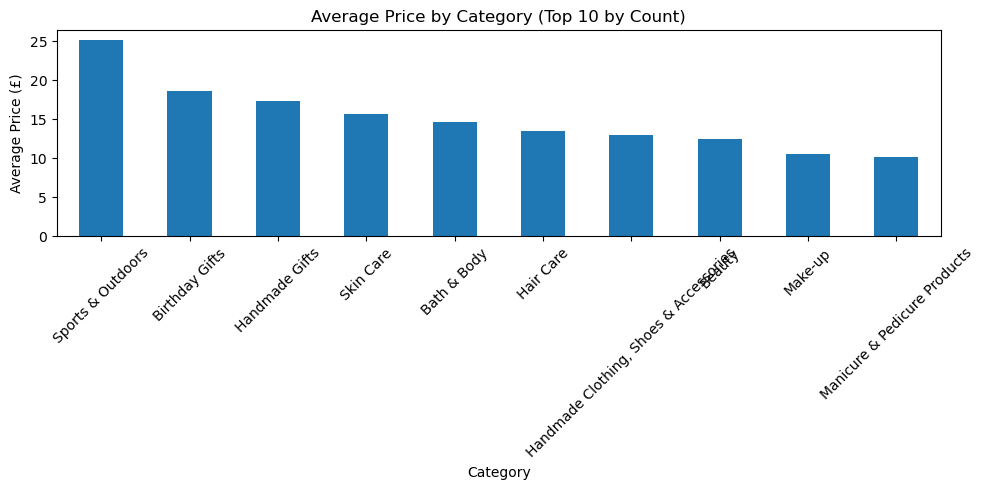

In [25]:
# Top 10 categories by count
top_10 = df_no_outliers['category'].value_counts().head(10).index
avg_prices = df_no_outliers[df_no_outliers['category'].isin(top_10)].groupby('category')['price'].mean().sort_values(ascending=False)

# Plot bar chart
plt.figure(figsize=(10, 5))
avg_prices.plot(kind='bar')
plt.title('Average Price by Category (Top 10 by Count)')
plt.ylabel('Average Price (£)')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


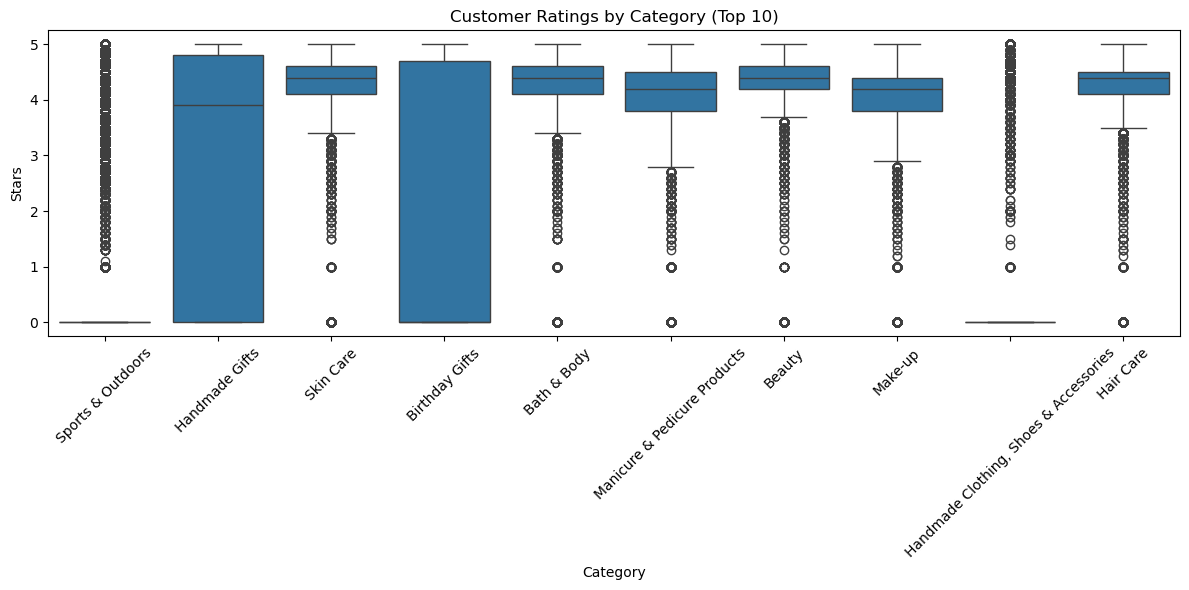

In [27]:
# Filter top 10 categories again
top_10_cat = df_no_outliers['category'].value_counts().head(10).index
box_df = df_no_outliers[df_no_outliers['category'].isin(top_10_cat)]

# Plot box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=box_df, x='category', y='stars')
plt.title('Customer Ratings by Category (Top 10)')
plt.ylabel('Stars')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [29]:
# Clean 'stars' and 'price' columns
df_no_outliers['stars'] = pd.to_numeric(df_no_outliers['stars'], errors='coerce')
df_no_outliers['price'] = pd.to_numeric(df_no_outliers['price'], errors='coerce')

# Drop missing values
corr_df = df_no_outliers[['price', 'stars']].dropna()

# Calculate Pearson correlation
corr_value, p_value = pearsonr(corr_df['price'], corr_df['stars'])

print(f" Correlation coefficient (Price vs Stars): {corr_value:.3f}")
print(f" P-value: {p_value:.3f}")


 Correlation coefficient (Price vs Stars): -0.078
 P-value: 0.000


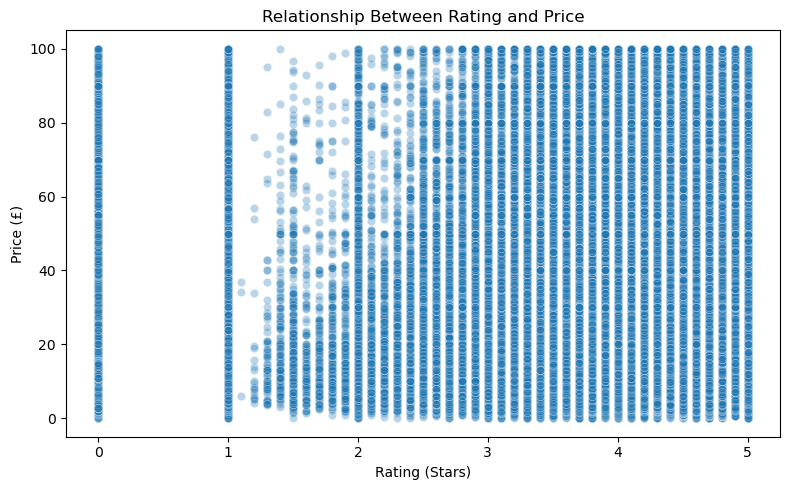

In [31]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=corr_df, x='stars', y='price', alpha=0.3)
plt.title("Relationship Between Rating and Price")
plt.xlabel("Rating (Stars)")
plt.ylabel("Price (£)")
plt.tight_layout()
plt.show()


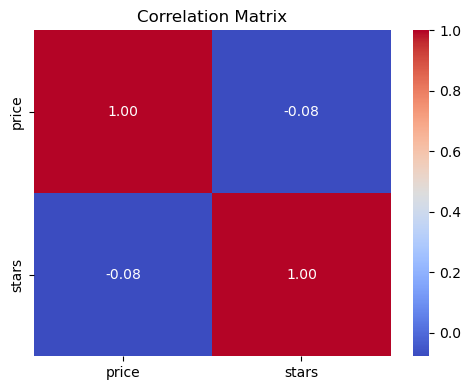

In [33]:
plt.figure(figsize=(5, 4))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


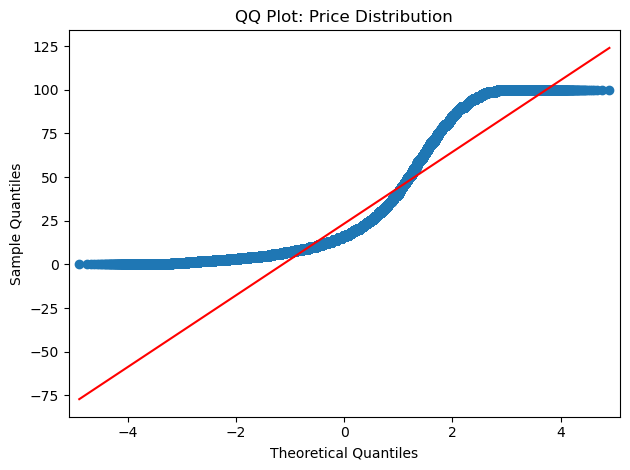

In [35]:
import statsmodels.api as sm

sm.qqplot(corr_df['price'], line='s')
plt.title("QQ Plot: Price Distribution")
plt.tight_layout()
plt.show()
